# ORF recognition by CNN

Alien with libcudnn8 after clear cache.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-08-12 08:23:21 EDT'

In [2]:
PC_SEQUENCES=10000   # how many protein-coding sequences
NC_SEQUENCES=10000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=32            # how long is each sequence
CDS_LEN=16            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.0
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

CoLab not working. On my PC, use relative paths.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


2021-08-12 08:23:21.727487: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 27 trials to reach 10 per class.
It took 48295 trials to reach 11000 per class.
Use 11000 PC seqs
Use 11000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 32.0
Average ORF length: 19.638272727272728
NC seqs
Average RNA length: 32.0
Average ORF length: 2.844


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (32, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 32, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 16)            784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 16)            784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
flatten (Flatten)         

2021-08-12 08:23:22.904594: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-12 08:23:22.963955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-12 08:23:22.964473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2021-08-12 08:23:22.964495: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-12 08:23:22.966316: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-12 08:23:22.966340: I tensorflow/stream_executor

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/100


2021-08-12 08:23:23.531924: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-12 08:23:23.556149: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2496000000 Hz
2021-08-12 08:23:30.300159: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-12 08:23:30.456550: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-08-12 08:23:30.793773: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 29/417 [=>............................] - ETA: 0s - loss: 0.7314 - accuracy: 0.5376   

2021-08-12 08:23:31.119997: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


417/417 [==============================] - 9s 3ms/step - loss: 0.6702 - accuracy: 0.5863 - val_loss: 0.5458 - val_accuracy: 0.7393


2021-08-12 08:23:32.618259: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/100
417/417 [==============================] - 1s 2ms/step - loss: 0.5319 - accuracy: 0.7493 - val_loss: 0.4807 - val_accuracy: 0.7882
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/100
417/417 [==============================] - 1s 2ms/step - loss: 0.4600 - accuracy: 0.7922 - val_loss: 0.4288 - val_accuracy: 0.8128
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/100
417/417 [==============================] - 1s 2ms/step - loss: 0.4130 - accuracy: 0.8143 - val_loss: 0.3944 - val_accuracy: 0.8262
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3712 - accuracy: 0.8337 - val_loss: 0.3795 - val_accuracy: 0.8287
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 6/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3481 - accuracy: 0.8439 - val_loss: 0.3619 - val_accuracy: 0.8335
INFO:tensorflow:Assets wr

Epoch 52/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0988 - accuracy: 0.9686 - val_loss: 0.3263 - val_accuracy: 0.8878
Epoch 53/100
417/417 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9624 - val_loss: 0.3306 - val_accuracy: 0.8845
Epoch 54/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0963 - accuracy: 0.9672 - val_loss: 0.3198 - val_accuracy: 0.8824
Epoch 55/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0906 - accuracy: 0.9718 - val_loss: 0.3314 - val_accuracy: 0.8824
Epoch 56/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0923 - accuracy: 0.9690 - val_loss: 0.3342 - val_accuracy: 0.8808
Epoch 57/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0879 - accuracy: 0.9716 - val_loss: 0.3292 - val_accuracy: 0.8799
Epoch 58/100
417/417 [==============================] - 1s 2ms/step - loss: 0.1034 - accuracy: 0.9618 - val_loss: 0.3439 - val_accuracy:

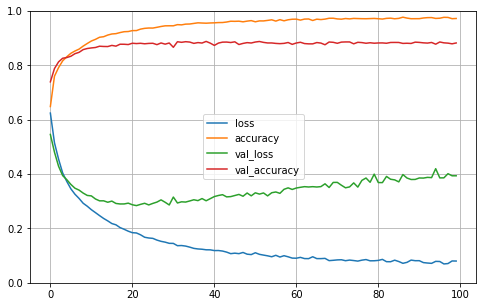

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/100
417/417 [==============================] - 2s 3ms/step - loss: 0.6602 - accuracy: 0.6070 - val_loss: 0.5565 - val_accuracy: 0.7321
Epoch 2/100
417/417 [==============================] - 1s 2ms/step - loss: 0.5383 - accuracy: 0.7439 - val_loss: 0.4995 - val_accuracy: 0.7699
Epoch 3/100
417/417 [==============================] - 1s 2ms/step - loss: 0.4815 - accuracy: 0.7815 - val_loss: 0.4584 - val_accuracy: 0.7887
Epoch 4/100
417/417 [==============================] - 1s 2ms/step - loss: 0.4243 - accuracy: 0.8102 - val_loss: 0.4170 - val_accuracy: 0.8073
Epoch 5/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3853 - accuracy: 0.8260 - val_loss: 0.3797 - val_accuracy: 0.8302
Epoch 6/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3447 - accuracy: 0.8526 - val_loss: 0.3582 - val_accuracy: 0.8392
Epoch 7/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3204 - accuracy: 0.8660 -

417/417 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.9704 - val_loss: 0.2853 - val_accuracy: 0.8970
Epoch 56/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0905 - accuracy: 0.9696 - val_loss: 0.2800 - val_accuracy: 0.8971
Epoch 57/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0824 - accuracy: 0.9711 - val_loss: 0.2884 - val_accuracy: 0.8928
Epoch 58/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0903 - accuracy: 0.9693 - val_loss: 0.2824 - val_accuracy: 0.8988
Epoch 59/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0795 - accuracy: 0.9752 - val_loss: 0.2906 - val_accuracy: 0.8959
Epoch 60/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0775 - accuracy: 0.9755 - val_loss: 0.3028 - val_accuracy: 0.8959
Epoch 61/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0850 - accuracy: 0.9704 - val_loss: 0.3005 - val_accuracy: 0.8916
Epoch

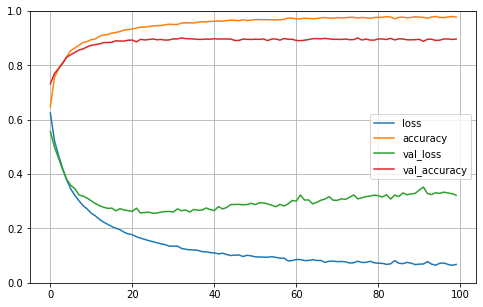

MODEL
make_DNN
input shape: (32, 4)
FIT
Epoch 1/100
417/417 [==============================] - 2s 3ms/step - loss: 0.6564 - accuracy: 0.6123 - val_loss: 0.5463 - val_accuracy: 0.7333
Epoch 2/100
417/417 [==============================] - 1s 2ms/step - loss: 0.5253 - accuracy: 0.7523 - val_loss: 0.4832 - val_accuracy: 0.7733
Epoch 3/100
417/417 [==============================] - 1s 2ms/step - loss: 0.4568 - accuracy: 0.7843 - val_loss: 0.4292 - val_accuracy: 0.8014
Epoch 4/100
417/417 [==============================] - 1s 2ms/step - loss: 0.4122 - accuracy: 0.8075 - val_loss: 0.3886 - val_accuracy: 0.8206
Epoch 5/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3645 - accuracy: 0.8318 - val_loss: 0.3586 - val_accuracy: 0.8390
Epoch 6/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3332 - accuracy: 0.8507 - val_loss: 0.3427 - val_accuracy: 0.8533
Epoch 7/100
417/417 [==============================] - 1s 2ms/step - loss: 0.3109 - accuracy: 0.8696 -

Epoch 57/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0879 - accuracy: 0.9736 - val_loss: 0.2852 - val_accuracy: 0.8989
Epoch 58/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0830 - accuracy: 0.9738 - val_loss: 0.2844 - val_accuracy: 0.9023
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 59/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0829 - accuracy: 0.9768 - val_loss: 0.2972 - val_accuracy: 0.9010
Epoch 60/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0822 - accuracy: 0.9756 - val_loss: 0.2896 - val_accuracy: 0.8945
Epoch 61/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0882 - accuracy: 0.9714 - val_loss: 0.2976 - val_accuracy: 0.8987
Epoch 62/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0883 - accuracy: 0.9732 - val_loss: 0.2801 - val_accuracy: 0.9007
Epoch 63/100
417/417 [==============================] - 1s 2ms/step - loss: 0.0781 -

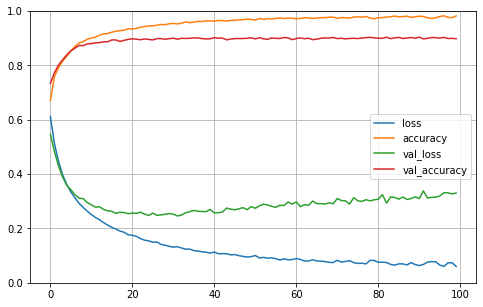

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 89.90%


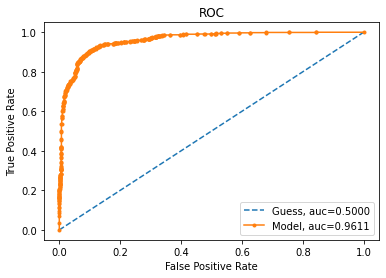

AUC: 96.11%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-08-12 08:28:08 EDT'